# Calculate Fermi beta angle from Navigation history data

### <span style="color:red; font-family:Georgia;">Robert Cameron, September 2015</span>

### Use Sun position calculation from http://aa.usno.navy.mil/faq/docs/SunApprox.php

In [1]:
# set plot time ranges

plot1 = ("2017-01-01","2020-01-01")
plot2 = ("2008-01-01","2020-01-01")

<IPython.core.display.Javascript object>


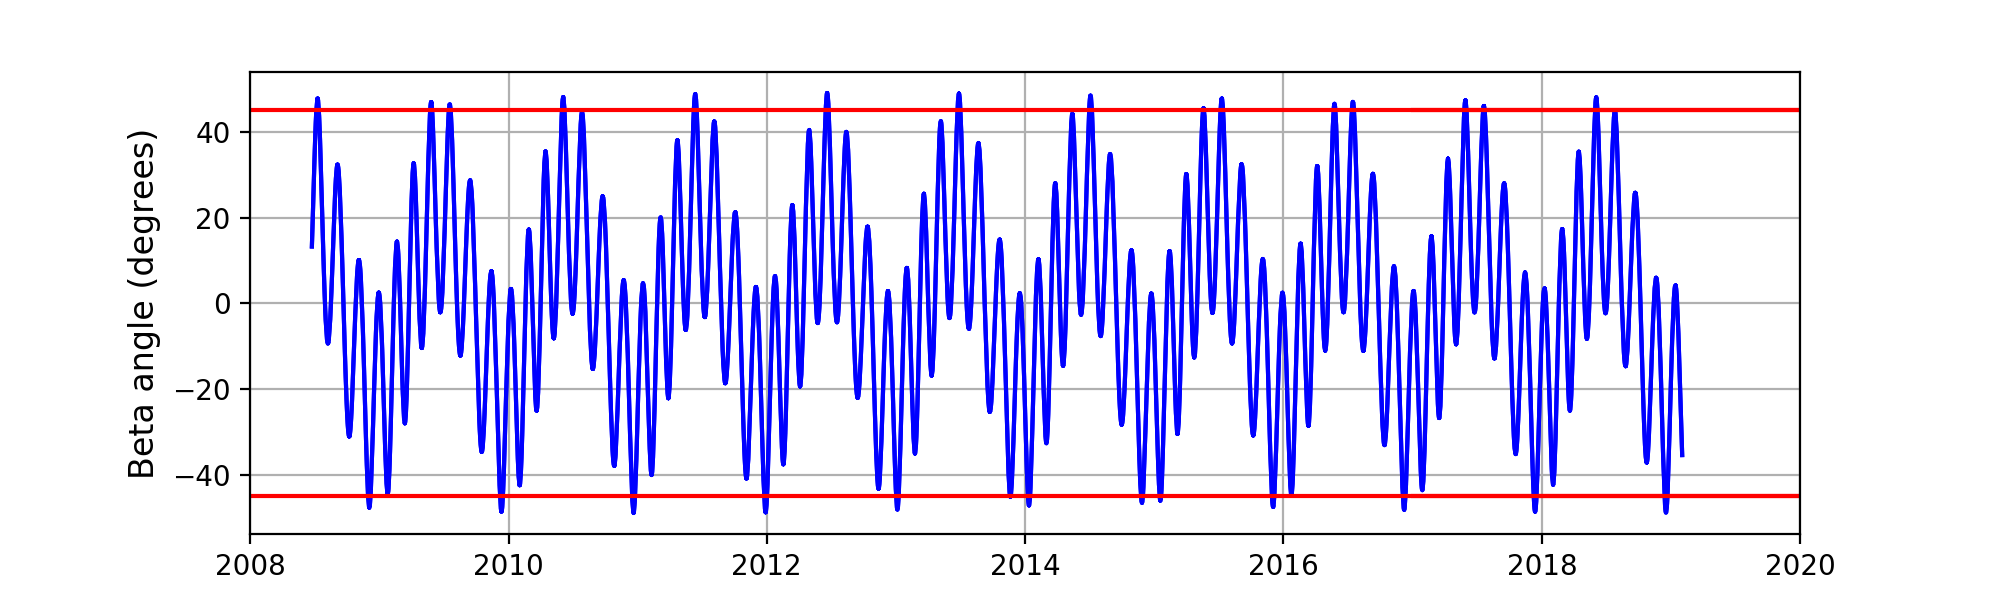

In [2]:
import numpy as np
import datetime as dt
from os.path import expanduser
HOME = expanduser("~")
from astropy.table import Table, Column
%matplotlib notebook
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
#%matplotlib notebook
#plt.rc('figure', figsize = [20, 6])
plt.figure(figsize = [10,3])
plt.rc('font', size = 10)

In [3]:
# read regular ASCII tabular file of Fermi navigation history
navfile = HOME+"/Documents/GLAST/ISOC/LATmetrics/beta/nav.history"
navtab = Table.read(navfile, format='ascii',names=('ymd','hms','s1970','x','y','z','vx','vy','vz'))
ymd = navtab['ymd']
hms = navtab['hms']
s1970 = navtab['s1970']
x = navtab['x']
y = navtab['y']
z = navtab['z']
vx = navtab['vx']
vy = navtab['vy']
vz = navtab['vz']
d1970 = s1970/86400.0
JD = d1970 + 2440587.5
DJ2000 = JD - 2451545.0

In [4]:
g = np.radians(357.529 + 0.98560028 * DJ2000)    # g = mean anomaly of the Sun
q = 280.459 + 0.98564736 * DJ2000  # q = mean longitude of the Sun, in degrees
L = np.radians(q + 1.915 * np.sin(g) + 0.020 * np.sin(2*g)) # L = geocentric apparent ecliptic longitude of the Sun, adjusted for aberration
rAU = 1.00014 - 0.01671 * np.cos(g) - 0.00014 * np.cos(2*g)  # rAU = Sun-Earth distance in AU
e = np.radians(23.439 - 0.00000036 * DJ2000)  # e = mean obliquity of the ecliptic
# get Sun's RA and Dec
tanRA = np.cos(e) * np.tan(L)
Zsun = np.sin(e) * np.sin(L)
sun_Dec = np.arcsin(Zsun)
sun_RA = np.arctan(np.cos(e) * np.sin(L),np.cos(L))
Xsun = np.cos(sun_Dec) * np.cos(sun_RA)
Ysun = np.cos(sun_Dec) * np.sin(sun_RA)
# normalize the Fermi position and velocity vectors
pos = np.sqrt(x*x + y*y + z*z)
vel = np.sqrt(vx*vx + vy*vy + vz*vz)
xn = x/pos
yn = y/pos
zn = z/pos
vxn = vx/vel
vyn = vy/vel
vzn = vz/vel
# get the vector to the Fermi orbit pole from the cross product of the Fermi position and velocity vectors
Polex = yn*vzn - zn*vyn
Poley = zn*vxn - xn*vzn
Polez = xn*vyn - yn*vxn
# calculate angle between Sun Vector and Fermi orbit pole, using dot product
# NOTE: beta angle is the complement of the angle from the dot product, so use sin instead of cos
sinbeta = Xsun*Polex + Ysun*Poley + Zsun*Polez
beta = np.degrees(np.arcsin(sinbeta))

In [5]:
doyformat = "%j"
doy = [dt.datetime.strptime(ymd[i],"%Y-%m-%d").timetuple().tm_yday for i in range(len(ymd))]
dntformat = "%Y-%m-%d%H:%M:%S"
dnt = [dt.datetime.strptime(ymd[i]+hms[i],dntformat) for i in range(len(ymd))]

In [6]:
datemin1 = dt.datetime.strptime(plot1[0],"%Y-%m-%d")
datemax1 = dt.datetime.strptime(plot1[1],"%Y-%m-%d")
plt.xlim(datemin1, datemax1)
plt.grid(True)
plt.ylabel('Beta angle (degrees)',fontsize='large')
plt.plot(dnt,beta,'b')
#plt.xaxis.set_minor_locator(mdates.YearLocator())
#plt.autofmt_xdate()
plt.plot([datemin1,datemax1],[45,45],'r')
plt.plot([datemin1,datemax1],[-45,-45],'r')

In [7]:
datemin2 = dt.datetime.strptime(plot2[0],"%Y-%m-%d")
datemax2 = dt.datetime.strptime(plot2[1],"%Y-%m-%d")
plt.xlim(datemin2, datemax2)
plt.grid(True)
plt.ylabel('Beta angle (degrees)',fontsize='large')
plt.plot(dnt,beta,'b')
#plt.xaxis.set_minor_locator(mdates.YearLocator())
#plt.autofmt_xdate()
plt.plot([datemin2,datemax2],[45,45],'r')
plt.plot([datemin2,datemax2],[-45,-45],'r')

In [8]:
arr = {'YMD':ymd,'DOY':doy,'HMS':hms,'rAU':Column(data=rAU,name='rAU',format='%f8'),'beta':Column(data=beta,name='beta',format='%f8')}
tout = Table(arr,names=('YMD','DOY','HMS','rAU','beta'))
tout.write(HOME+'/Documents/GLAST/ISOC/LATmetrics/beta/betang.txt',format='ascii', overwrite=True)